In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML("<style>.container { width: 90% !important; }</style>")

In [2]:
import utils

import sneks
import gym

from tqdm.notebook import trange
import numpy as np
import torch
import torch.nn as nn

utils.info

{'torch_version': '1.3.1', 'torch_device': 'cuda', 'gym_version': '0.17.1'}

In [3]:
utils.use_virtual_display()

':1061'

In [4]:
# env = gym.make('snek-rgb-16-v1')
env = gym.make('CartPole-v1')

observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)

num_actions = env.action_space.n
obs_size = np.prod(env.observation_space.shape)

obs_size, num_actions, env.reward_range, # env.unwrapped.unwrapped.get_action_meanings()

(4, 2, (-inf, inf))

In [5]:
dqn = utils.DQNAgent(obs_size, num_actions)

dqn_persist, dqn_load_if_exists = utils.model_persistor(dqn, './.models/dqn2.pkl')
dqn_load_if_exists()

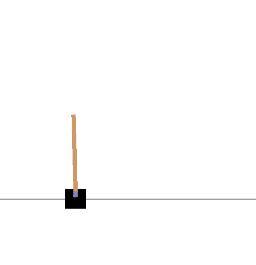

In [6]:
frames_generator = utils.play_env(env, dqn, duration=100)
utils.i_python_display_frames(frames_generator, fps=60)

In [7]:
generator = utils.ExperienceGenerator()(env, dqn, bs=100)
batch = next(generator)
[t.shape for t in batch]

[(100, 4), (100,), (100,), (100, 4), (100,)]

In [8]:
# %matplotlib notebook
# its = 10_000

# generator = utils.ExperienceGenerator()
# next_batch = generator(env, dqn, bs=128)
# optimize = dqn.optimizer(next_batch, lr=0.001)
# plotter = utils.Plotter()

# tr = trange(its, bar_format="{bar}{l_bar}{r_bar}")
# for i in tr:
#     info = next(optimize)
#     plotter.log(**info)
#     plotter.log(episode_rewards=generator.episode_rewards[:-1])
#     plotter.log(randomness_list=generator.randomness_list)

#     tr.set_description(' | '.join([
#         'LOSS: %.6f' % info['loss'],
#         'EP REWARD: %.2f' % np.mean(generator.episode_rewards[-5:-1]),
#     ]))

#     if i % 200 == 0: plotter.plot()

In [9]:
# dqn_persist()

In [10]:
# frames_generator = utils.play_env(env, dqn, duration=100)
# utils.i_python_display_frames(frames_generator, fps=60)

In [11]:
def render_rollout():
    gen = utils.rollout_generator(env, agent=dqn, bs=16, max_seq_len=20, buffer_size=50)
    for ep_id, actions, observations, renders_batch in gen:
        for renders in renders_batch:
            for r in renders:
                yield r

In [12]:
# utils.i_python_display_frames(render_rollout(), fps=30)

In [13]:
g = utils.rollout_generator(env, agent=dqn, bs=16, max_seq_len=20, buffer_size=50)
batch = next(g)
[b.shape for b in batch]

[(16,), (16, 20), (16, 20, 4), (16, 20, 400, 600, 3)]

In [ ]:
np.random.permutation(10)

In [ ]:
np.array()

In [ ]:
a = [1,2,3,4]
a

In [ ]:
batch = [
    [1,2],
    [3,4],
    [5,6,7],
]
batch = [np.array(t) for t in batch]
batch

In [ ]:
max_shape = np.array([el.shape for el in batch]).max(axis=0)
max_shape = (len(batch), *max_shape)
max_shape

In [ ]:
padded = np.zeros(max_shape)
padded

In [ ]:
for el in padded:
    el[]

In [ ]:
env.action_space.shape

In [ ]:
padded[...]